Now the goal is to collapse the independent yield covariances calculated in the `generate_one.ipynb` notebook into cumulative yield covariances. The equation to calculate the cumulative yield of species from the independent yields of that species and its parents is:

\begin{equation}
Y_C(Z_j,A_j) = \sum_i Y_I(Z_i,A_i)\, P(Z_i,A_i \rightarrow Z_j,A_j) 
\end{equation}

where $P(Z_i,A_i \rightarrow Z_j,A_j)$ is the probability that a species with $Z_i$ and $A_i$ will transmute via radioactive decay to a species with $Z_j$ and $A_j$ and is given by:

\begin{equation}
P(Z_i,A_i \rightarrow Z_j,A_j) = \prod_{k=i}^j \beta_k
\end{equation}

where $\beta_k$ is the decay branching ratio of a species with $Z_k$ and $A_k$ to its daughter.

Set the system:

In [1]:
system = 'U235F'
evaluation = 'ENDF'
element = 'U'
At = 235
energy = 'fission'

Import statements and globals:

In [2]:
TRIALS = 10000
from math import sqrt
import numpy
import matplotlib.pyplot as plt
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

Import a list of radioactive decays and branching ratios:

In [3]:
file = open( 'FIER/FIER/input_data/decays.csv', 'r' )
lines = file.readlines()
file.close()

decays = {}
for line in lines: 
    Zp = int( line.split(',')[0] )
    Ap = int( line.split(',')[1] )
    Ip = int( line.split(',')[2] )
    BR = float( line.split(',')[5] ) / 100.0
    BR_unc = float( line.split(',')[6] ) / 100.0
    Zd = int( line.split(',')[7] )
    Ad = int( line.split(',')[8] )
    Id = int( line.split(',')[9] )
    try:
        decays[Zp,Ap,Ip][Zd,Ad,Id] = (BR, BR_unc)
    except KeyError as e:
        decays[Zp,Ap,Ip] = {}
        decays[Zp,Ap,Ip][Zd,Ad,Id] = (BR, BR_unc)

Run `FIER` to generate decay stems for the system:

In [4]:
file = open( 'FIER/FIER/deck.txt', 'w' )
file.write( 'MODE:SINGLE\n' )
file.write( 'ON DECAY PREDICTION\n' )
file.write( 'input_data/isotopes.csv     ISOTOPES FILE\n' )
file.write( 'input_data/decays.csv       DECAYS   FILE\n' )
file.write( 'input_data/gammas.csv       GAMMAS   FILE\n' )
file.write( 'YIELDS:FILE\n' )
file.write( '../../yields/' + evaluation + '/independent/' + system + '.csv\n' )
file.write( 'NONE  CHAINS OUTPUT\n' )
file.write( 'output/decay_stems.csv   STEMS OUTPUT\n' )
file.write( 'NONE  POPS OUTPUT\n' )
file.write( 'NONE   GAMMAS OUTPUT\n' )
file.write( 'NONE  ERROR LOG\n' )
file.write( 'INITIALIZE\n' )
file.write( 'IRRADIATION\n' )
file.write( '1.0,1.0\n' )
file.write( 'POPULATIONS\n' )
file.write( 'COUNTS\n' )
file.write( 'END\n' )
file.close()
!cd FIER/FIER && make > /dev/null

Read in the decay stems:

In [5]:
file = open( 'FIER/FIER/output/decay_stems.csv', 'r' )
lines = file.readlines()
file.close()

stems = []
sublines = []
for i in range(0,len(lines)):
    line = lines[i]
    if( not('------' in line) ):
        sublines.append( line )
    else:
        sublines = sublines[1:]
        subsublines = [ [] ]
        cur = 0
        for j in range(0,len(sublines)):
            if( not('---' in sublines[j]) ):
                subsublines[cur].append( sublines[j] )
            else:
                cur += 1
                subsublines.append( [] )
        
        subsublines = subsublines[:-1]
        for sub in subsublines:
            stem = []
            for subsub in sub:
                Z = int( subsub.split(',')[0] )
                A = int( subsub.split(',')[1] )
                I = int( subsub.split(',')[2] )
                stem.append( (Z,A,I) )
            stems.append( stem )
        
        sublines = []

Calculate the transmutation probability from one species to another: 

In [6]:
trans_probs = {}
for stem in stems:
    key = (stem[0][0],stem[0][1],stem[0][2],stem[len(stem)-1][0],stem[len(stem)-1][1],stem[len(stem)-1][2])
    prob = 1.0
    prob_unc = 0.0
    for i in range(1,len(stem)):
        decay = decays[stem[i-1][0],stem[i-1][1],stem[i-1][2]][stem[i][0],stem[i][1],stem[i][2]]
        prob = prob * decay[0] 
        prob_unc += ( decay[1] / decay[0] )**2.0
    prob_unc = prob * sqrt( prob_unc )
    trans_probs[key] = ( prob, prob_unc )

Import the yields for the selected `system`: 

In [7]:
file = open( 'yields/' + evaluation + '/independent/' + system + '.csv', 'r' )
lines = file.readlines()
file.close()
A_min = 300
A_max = 0
yields = {}
yields_unc = {}
for line in lines:
    parts = line.split(',')
    Z = int( parts[0] )
    A = int( parts[1] )
    I = int( parts[2] )
    Y = float( parts[3] )
    Y_unc = float( parts[4] )
    if( A < A_min ):
        A_min = A
    if( A > A_max ):
        A_max = A
    yields[Z,A,I] = Y
    yields_unc[Z,A,I] = Y_unc

Import the covariance matrix for the independent yields:

In [8]:
file = open( 'matrices/' + evaluation + '/independent/' + system + '_cov.csv', 'r' )
lines = file.readlines()
file.close()

inds = []
Y = []
parts = lines[0].split(',')[1:]
for part in parts:
    val = int(part)
    Z = int(val/10000)
    I = int( (val - Z*10000)/1000 )
    A = val - Z*10000 - I*1000
    inds.append( (Z,A,I) )
    try:
        Y.append( yields[Z,A,I] )
    except KeyError as e:
        Y.append( 0.0 )

n = len( inds )
Y_cov = numpy.zeros( (n,n) )

for i in range(1,len(lines)):
    parts = lines[i].split(',')[1:]
    for j in range(0,len(parts)):
        Y_cov[i-1,j] = float( parts[j] )

Calculate the cumulative yields `n = TRIALS` times using resampled independent yields: 

In [9]:
numpy.random.seed(0)
trials_res = numpy.zeros( (len(inds),TRIALS) )
for n in range(0,TRIALS):
    yields_vard = numpy.random.multivariate_normal( Y, Y_cov )
    yields_vard_dict = {}
    for i in range(0,len(inds)):
        yields_vard_dict[inds[i]] = yields_vard[i]
    
    yields_cml = {}
    for key in trans_probs:
        prob = numpy.random.normal( trans_probs[key][0], trans_probs[key][1] )
        try:
            yields_cml[key[3],key[4],key[5]] += prob * yields_vard_dict[key[3],key[4],key[5]]
        except KeyError as e:
            try:
                yields_cml[key[3],key[4],key[5]] = prob * yields_vard_dict[key[3],key[4],key[5]]
            except KeyError as e:
                pass
    
    for i in range(0,len(inds)):
        trials_res[i,n] = yields_cml[inds[i]]

Calculate the correlation and covariance matrix:

In [10]:
yields_corr = numpy.corrcoef( trials_res )
yields_cov = numpy.cov( trials_res )

Generate "normalized" correlation and covariance matrices such that the diagonal of the covariance matrix has the same variance as the evaluation. 

This cannot be done simply with: 

\begin{equation}
\Sigma[i,j] = \sigma_i \sigma_j \rho[i,j]
\end{equation}

where $\sigma_i$ and $\sigma_j$ are the uncertainties from the evaluation and $\rho$ are the correlation values. 

This leads to a covariance matrix summing to a non-zero value (to within numerical precision). This violates yield conservation in resampled libraries. 

Instead scale the negative correlations (or positive correlations) to have the sum of the normalized covariance matrix be zero.

Import the England and Rider cumulative yields and generate a covariance matrix based on the evaluated cumulative yield uncertainties and the above correlation matrix: 

In [11]:
file = open( 'yields/' + evaluation + '/cumulative/' + system + '_cml.csv', 'r' )
lines = file.readlines()
file.close()

yields = {}
yields_unc = {}
key_list = inds[:]
for line in lines:
    parts = line.split(',')
    Z = int( parts[0] )
    A = int( parts[1] )
    I = int( parts[2] )
    Y = float( parts[3] )
    Y_unc = float( parts[4] )
    yields[Z,A,I] = Y
    yields_unc[Z,A,I] = Y_unc

df_std = []
df_stdT = []
for key in key_list:
    try:
        df_std.append( yields_unc[key] )
        df_stdT.append( [yields_unc[key]] )
    except KeyError as e:
        df_std.append( 0.0 )
        df_stdT.append( [0.0] )
df_std = numpy.array( df_std )
df_stdT = numpy.array( df_stdT )
yields_cov_prenorm = df_std * yields_corr * df_stdT

total_sum = yields_cov_prenorm.sum()
if( total_sum > 0.0 ):
    non_diag = yields_cov_prenorm[:,:]
    numpy.fill_diagonal( non_diag, 0.0 )
    negative_sum = abs( non_diag[non_diag < 0.0].sum() )
    norm = (total_sum + negative_sum) / negative_sum
    yields_corr_norm = yields_corr[:,:]
    yields_corr_norm[non_diag < 0.0] *= norm
    yields_corr_norm[yields_corr_norm < -1.0] = -1.0
    yields_cov_norm = df_std * yields_corr_norm * df_stdT
elif( total_sum < 0.0 ):
    non_diag = yields_cov_prenorm[:,:]
    numpy.fill_diagonal( non_diag, 0.0 )
    positive_sum = non_diag[non_diag > 0.0].sum()
    norm = (total_sum + positive_sum) / positive_sum
    yields_corr_norm = yields_corr[:,:]
    yields_corr_norm[non_diag > 0.0] *= norm
    yields_corr_norm[yields_corr_norm > 1.0] = 1.0
    yields_cov_norm = df_std * yields_corr_norm * df_stdT

Plot the correlation matrix:

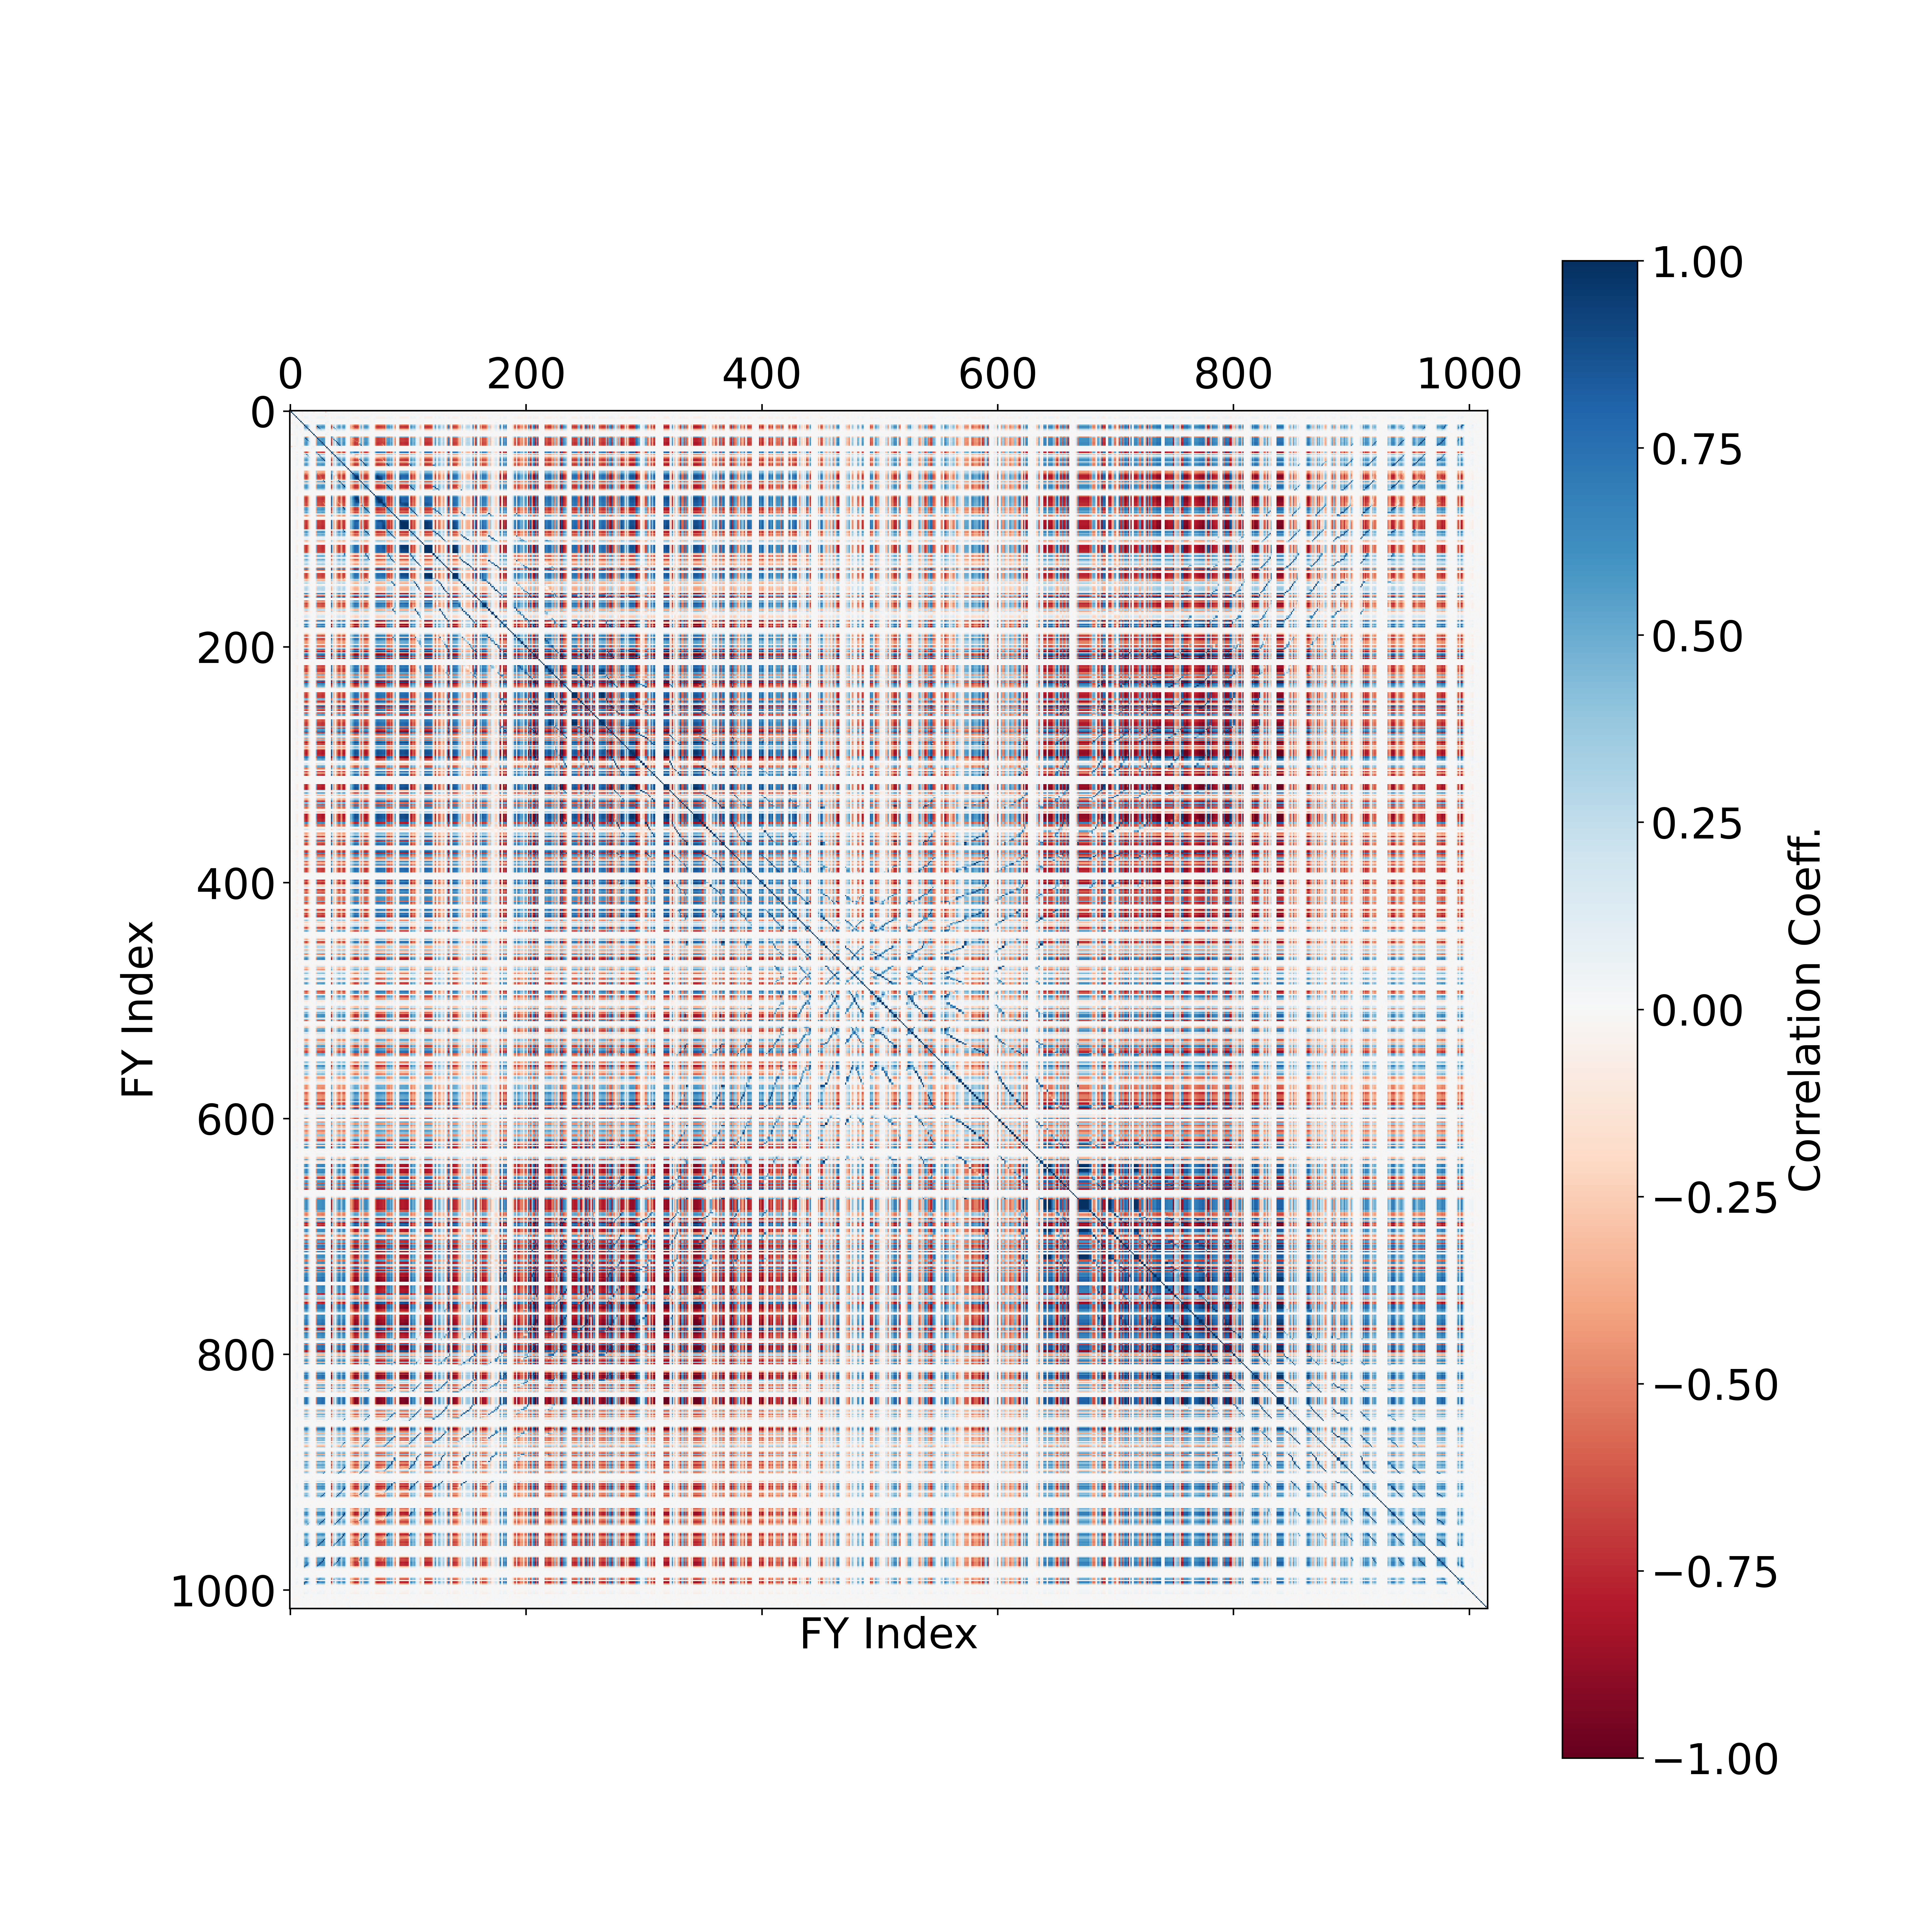

<Figure size 1008x1008 with 0 Axes>

In [12]:
rcParams['figure.figsize'] = 14, 14
rcParams['font.size'] = 22
plt.matshow(yields_corr,cmap="RdBu",vmin=-1.0,vmax=1.0)
cbar = plt.colorbar()
cbar.set_label('Correlation Coeff.')
plt.tight_layout()
plt.xlabel('FY Index')
plt.ylabel('FY Index')
plt.savefig( 'figures/' + system + '_cml_corr_example.png', dpi=500 )
plt.clf()
Image( 'figures/' + system + '_cml_corr_example.png' )